# Práctica de Detección de Rostros Reales y Falsos con Redes Neuronales Convolucionales (CNN) en PyTorch

## 1. Importación de las librerías

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision import models, transforms
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import wandb
import pandas as pd

- Seguimiento y la visualización de experimentos mediante Wandb
- Establecimiento de las semillas para garantizar la reproducibilidad de los resultados

In [7]:
wandb.init(project="FaceRecognition", name="FaceNetRecognition")

seed = 42 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## 2. Importación de Datos

In [8]:
DATASET = os.path.abspath('real_and_fake_face/')
INITIAL_SIZE_OF_IMAGES = (160, 160)

- Redimensión de las imágenes
- Transformación a tensores
- Normalización de las imágenes

In [70]:
data_transforms = transforms.Compose([
    transforms.Resize(INITIAL_SIZE_OF_IMAGES),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root=DATASET, transform=data_transforms)

nombres_clases = dataset.classes

for i, clase in enumerate(nombres_clases):
    print(f"Clase {i}: {clase}")

Clase 0: training_fake
Clase 1: training_real


- Configuración de la GPU

In [10]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando {device} para entrenar')

Usando cpu para entrenar


## 3. Aumento masivo de datos

In [11]:
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

test_dataset.transform = data_transforms

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False)

massive_data_augmentation = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización
])

train_dataset.dataset.transform = massive_data_augmentation
valid_dataset.dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### 3.1 Inicialización del algoritmo K-folds

In [7]:
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
combined_dataset = train_dataset + valid_dataset

combined_labels = [label for _, label in combined_dataset]

## 4. Configuración del modelo pre-entrenado-

In [8]:
resnet18 = models.resnet18(pretrained=True)

c:\Users\Susana\anaconda3\envs\aa2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Susana\anaconda3\envs\aa2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- Congelación de los gradientes.

In [9]:
for param in resnet18.parameters():
    param.requires_grad = False

- Modificación de la Capa de Clasificación de ResNet-18

In [10]:
resnet18.fc = nn.Sequential(
    nn.Linear(resnet18.fc.in_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(256, 2),
)

## 5. Reentrenamiento de la última capa.

In [11]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(resnet18.parameters(), lr=0.001, weight_decay=0.001)

In [12]:
def train(num_epochs, model, train_loader, valid_loader):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        training_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()


        avg_train_loss = training_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)
        valid_accuracy = 100 * correct_valid / total_valid
        valid_accuracies.append(valid_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')
        wandb.log({"Train Loss": avg_train_loss, "Train Acc": train_accuracy, "Valid Loss": avg_valid_loss, "Valid Acc": valid_accuracy})
    
    return model, train_losses, valid_losses, train_accuracies, valid_accuracies

In [13]:
num_epochs = 10

for fold, (train_index, valid_index) in enumerate(skf.split(np.zeros(len(combined_labels)), combined_labels)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    train_fold = torch.utils.data.Subset(combined_dataset, train_index)
    valid_fold = torch.utils.data.Subset(combined_dataset, valid_index)

    train_loader = torch.utils.data.DataLoader(dataset=train_fold, batch_size=64, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(dataset=valid_fold, batch_size=64, shuffle=False)
    
    model, train_losses, valid_losses, train_accuracies, valid_accuracies = train(num_epochs, resnet18, train_loader, valid_loader)
    
print("Entrenamiento finalizado!")
    

Fold 1/5
Epoch [1/10], Train Loss: 0.7014, Train Acc: 54.70%, Valid Loss: 0.6759, Valid Acc: 59.51%
Epoch [2/10], Train Loss: 0.6759, Train Acc: 58.11%, Valid Loss: 0.6607, Valid Acc: 64.13%
Epoch [3/10], Train Loss: 0.6495, Train Acc: 61.65%, Valid Loss: 0.6568, Valid Acc: 63.32%
Epoch [4/10], Train Loss: 0.6254, Train Acc: 63.56%, Valid Loss: 0.6514, Valid Acc: 64.95%
Epoch [5/10], Train Loss: 0.6365, Train Acc: 64.44%, Valid Loss: 0.6538, Valid Acc: 63.59%
Epoch [6/10], Train Loss: 0.6033, Train Acc: 66.96%, Valid Loss: 0.6684, Valid Acc: 63.86%
Epoch [7/10], Train Loss: 0.5962, Train Acc: 67.71%, Valid Loss: 0.6718, Valid Acc: 62.50%
Epoch [8/10], Train Loss: 0.5754, Train Acc: 68.80%, Valid Loss: 0.6681, Valid Acc: 64.95%
Epoch [9/10], Train Loss: 0.5884, Train Acc: 68.19%, Valid Loss: 0.6573, Valid Acc: 64.95%
Epoch [10/10], Train Loss: 0.5841, Train Acc: 68.05%, Valid Loss: 0.6567, Valid Acc: 63.86%
Fold 2/5
Epoch [1/10], Train Loss: 0.5908, Train Acc: 69.30%, Valid Loss: 0.5159

## 6. Visualización de Pérdida y Precisión durante el Entrenamiento

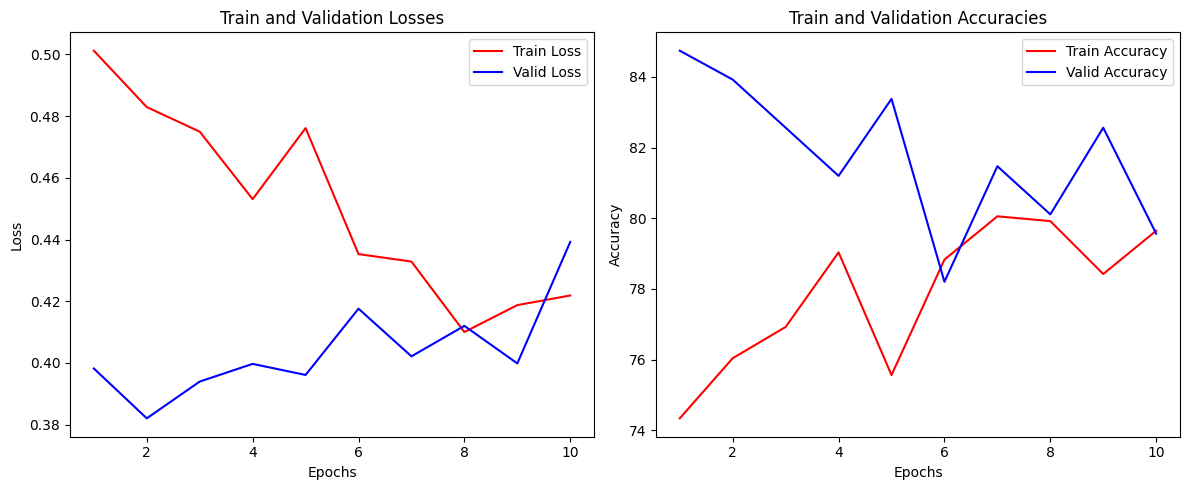

In [14]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Train Loss')
plt.plot(epochs, valid_losses, 'b', label='Valid Loss')
plt.title('Train and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r', label='Train Accuracy')
plt.plot(epochs, valid_accuracies, 'b', label='Valid Accuracy')
plt.title('Train and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 7. Guardar el modelo

In [15]:
model_save_path = 'resnet18_Adamw81.pth'
torch.save(resnet18, model_save_path)

## 8. Evaluación del modelo

In [3]:
model_save_path = 'resnet18_Adamw81_95.pth'

loaded_model = torch.load(model_save_path)

In [12]:
from sklearn.metrics import confusion_matrix,roc_curve, auc
import seaborn as sns
from io import BytesIO

### 8.1. Matriz de confusión.

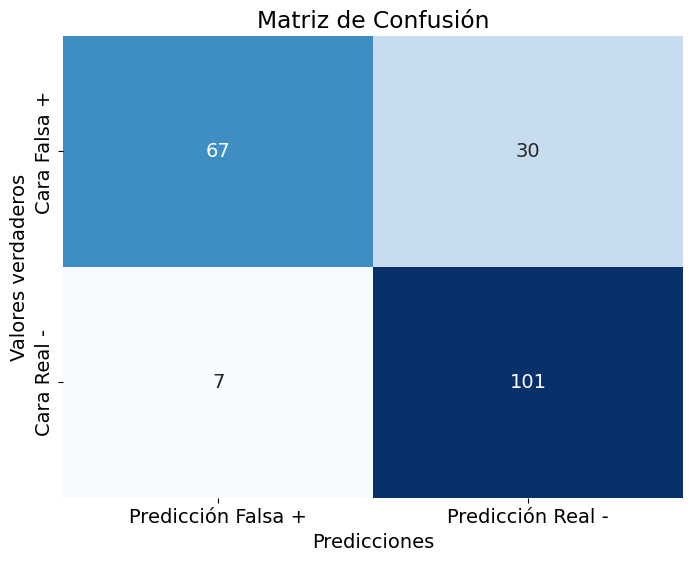

In [195]:
resnet18 = loaded_model
resnet18.eval()

predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
TN, FP, FN, TP = conf_matrix.ravel()

cara_falsa_como_real = []
cara_real_como_falsa = []

for i in range(len(true_labels)):
    if true_labels[i] == 0 and predicted_labels[i] == 1:
        cara_falsa_como_real.append(i)
    elif true_labels[i] == 1 and predicted_labels[i] == 0:
        cara_real_como_falsa.append(i)

class_labels = [['Predicción Falsa +', 'Predicción Real -'], ['Cara Falsa +', 'Cara Real -']]

plt.rc('font', size=14)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels[0], yticklabels=class_labels[1])
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de Confusión')
plt.savefig('./images/confusion_matrix.svg', format='svg', dpi=600)
plt.show()
plt.close()

confusion_matrix_image = wandb.Image('./images/confusion_matrix.svg', caption='Confusion Matrix')
wandb.log({"Confusion_matrix": confusion_matrix_image})

### 8.2. Visualización de predicciones erróneas.

In [175]:
def mostrar_imagenes_lado_a_lado(imagenes, true_label, label, ruta):
    _, axs = plt.subplots(1, 2, figsize=(9, 4))
    
    for i in range(2):
        axs[i].imshow(imagenes[i][0])
        axs[i].set_title(f'Clase: {true_label}')
        axs[i].text(0.5, -0.15, f'Predicción: {label}', fontsize=12, ha='center', transform=axs[i].transAxes)
        axs[i].axis('off')
    
    plt.savefig(ruta, format='svg', dpi=600)
    plt.show()
    plt.close()

In [167]:
def encontrar_imagen(index, dataset):
    for lote, (imagen, etiqueta) in enumerate(dataset):
        if lote == index:
            imagen_original = imagen * 0.5 + 0.5
            imagen_original = transforms.ToPILImage()(imagen_original)
            return imagen, etiqueta

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


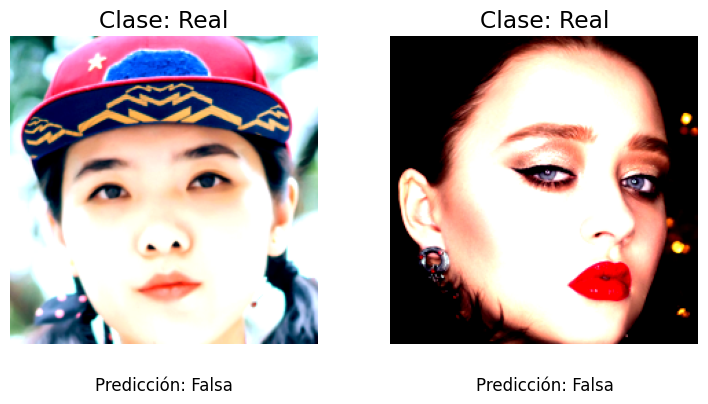

In [174]:
falsos_positivos_aleatorios = random.sample(cara_real_como_falsa, 2)
imagenes_originales = []
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

for i in falsos_positivos_aleatorios:
    imagen, etiqueta = encontrar_imagen(i, test_dataset)
    imagen = imagen.numpy().transpose(1, 2, 0)
    imagen = std * imagen + mean
    imagenes_originales.append((imagen,etiqueta))

mostrar_imagenes_lado_a_lado(imagenes_originales, "Real", "Falsa", './images/real_fake.svg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


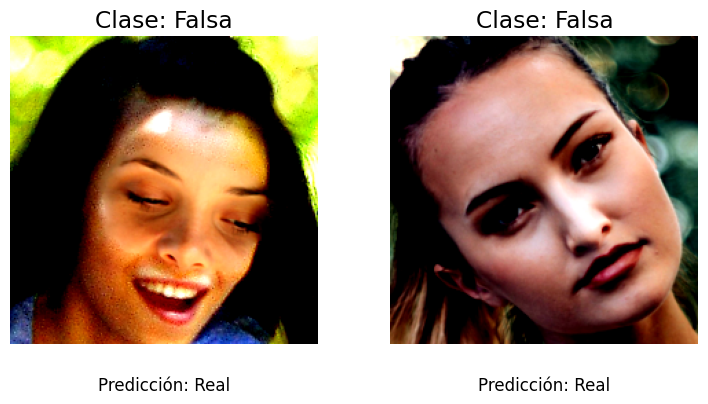

In [181]:
indices = random.sample(cara_falsa_como_real, 2)
imagenes_originales = []
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

for i in indices:
    imagen, etiqueta = encontrar_imagen(i, test_dataset)
    imagen = imagen.numpy().transpose(1, 2, 0)
    imagen = std * imagen + mean
    imagenes_originales.append((imagen,etiqueta))

mostrar_imagenes_lado_a_lado(imagenes_originales, "Falsa", "Real", './images/fake_real.svg')

### 8.3. Curva ROC

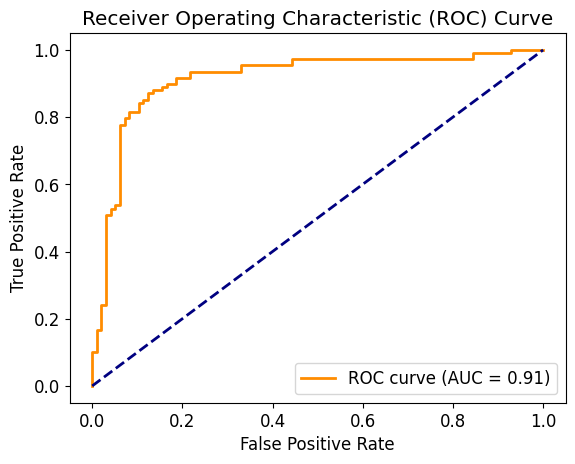

In [192]:
resnet18.eval()
with torch.no_grad():
    all_labels = []
    all_predictions = []
    for images, labels in test_loader:
        outputs = resnet18(images)
        predicted_probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted_probs.numpy())

all_predictions = np.array(all_predictions) 
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.rc('font', size=12)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('./images/curva_roc.svg', format='svg', dpi=600)
plt.show()
plt.close()

wandb.log({"ROC Curve": wandb.Image('curva_roc.png')})

## 8.4 Medidas formales de eficacia de la clasificación

In [193]:
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1] 
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

sensibilidad = TP / (TP + FN)
fpr = FP / (FP + TN)
especificidad = TN / (TN + FP)
predictivo_positivo = TP / (TP + FP)
predictivo_negativo = TN / (TN + FN)
exactitud = (TP + TN) / (TP + TN + FP + FN)
f_measure = 2/(1/predictivo_positivo + 1/sensibilidad)
correlacion_matthews = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
relacion_pos_similitud = sensibilidad / (1 - especificidad)
relacion_neg_similitud = (1 - sensibilidad) / especificidad

In [194]:
metricas = {
    'Sensibilidad (TPR)': [sensibilidad],
    'FPR': [fpr],
    'Especificidad': [especificidad],
    'Predictivo Positivo (PPV)': [predictivo_positivo],
    'Predictivo Negativo (NPV)': [predictivo_negativo],
    'Exactitud (Accuracy)': [exactitud],
    'F-Measure': [f_measure],
    'Correlación de Matthews': [correlacion_matthews],
    'Relación Positiva de Similitud': [relacion_pos_similitud],
    'Relación Negativa de Similitud': [relacion_neg_similitud]
}

df = pd.DataFrame(metricas)
display(df.transpose())

,0
Sensibilidad (TPR),0.935185
FPR,0.309278
Especificidad,0.690722
Predictivo Positivo (PPV),0.770992
Predictivo Negativo (NPV),0.905405
Exactitud (Accuracy),0.819512
F-Measure,0.845188
Correlación de Matthews,0.650663
Relación Positiva de Similitud,3.023765
Relación Negativa de Similitud,0.093836


## 8.5 Precisión del conjunto de test

In [20]:
resnet18.eval()
correct_test = 0
total_test = 0
false_positives = []
false_negatives = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet18(images)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        incorrect_mask = predicted != labels
        false_positive_mask = (predicted == 1) & (labels == 0)
        false_negative_mask = (predicted == 0) & (labels == 1)

        false_positives.append(images[false_positive_mask])
        false_negatives.append(images[false_negative_mask])

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 81.95%


In [23]:
wandb.finish()

Train Acc,▁▂▃▃▄▅▅▅▅▄▅▅▆▆▆▆▅▄▆▆▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇█████
Train Loss,█▇▇▆▆▅▅▅▅▆▆▅▅▅▄▄▅▅▄▄▄▄▄▃▄▄▄▃▃▃▃▂▃▃▃▂▂▂▁▁
Valid Acc,▁▂▂▃▂▂▃▃▆▄▅▅▄▅▅▅▄▆▆▆▅▆▅▅█▅▇▆▆▇▆▆██▇▇▆▇▇▇
Valid Loss,███▇████▄▆▆▅▅▅▅▅▅▄▃▄▄▄▅▄▂▃▂▃▃▃▂▃▁▁▁▁▂▁▂▂
Train Acc,79.64602
Train Loss,0.42188
Valid Acc,79.56403
Valid Loss,0.43923
